# Importing Libraries

In [ ]:
#Importing all the requied libraries , which I used in this Project.
import os
import pandas as pd
import pickle
import shutil
import numpy as np
import seaborn as sns
from sklearn.datasets import load_files
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

from PIL import ImageFile   
from sklearn.model_selection import train_test_split
from keras.preprocessing import image                  
from tqdm import tqdm

from keras.applications.vgg16 import VGG16

# Defining the train,test and model directories

* We will create the directories for train,test and model training paths if not present

In [ ]:
# That's are my model path directories 
TEST_DIR = os.path.join(os.getcwd(),"imgs","test")
TRAIN_DIR = os.path.join(os.getcwd(),"imgs","train")
MODEL_PATH = os.path.join(os.getcwd(),"model","vgg16_modified")
PICKLE_PATH = os.path.join(os.getcwd(),"pickle")
TEST_CSV = os.path.join(os.getcwd(),"csv_files","test.csv")
TRAIN_CSV = os.path.join(os.getcwd(),"csv_files","train.csv")

In [ ]:
# Using condition to confirm that have all above defined directories are their or not .
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
else:
    shutil.rmtree(MODEL_PATH)
    os.makedirs(MODEL_PATH)
if not os.path.exists(PICKLE_PATH):
    os.makedirs(PICKLE_PATH)

Model path does not exists
Model path created


As a result, a csv file will be created containing the locations of the training and test images, and their associated classes, if present, so that the data can be traced easily.

In [ ]:
# Use pandas library to read csv file of training and testing data set.
data_train = pd.read_csv(TRAIN_CSV)
data_test = pd.read_csv(TEST_CSV)

## Converting into numerical values

1 :- Using tolist() function returns a copy of the array elements as a Python list.
2 :- Using PKL file enabless objects to be serialized to files on disk and deserialized back into the program at runtime.
3 :- At the last converts a Python object hierarchy into a byte stream written to a buffer or to a disk file.

In [ ]:
labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}
print(labels_id)
data_train['ClassName'].replace(labels_id,inplace=True)

labels = to_categorical(data_train['ClassName'])
print(labels.shape)

with open(os.path.join(PICKLE_PATH,"labels_list_vgg16_modified.pkl"),"wb") as handle:
    pickle.dump(labels_id,handle)

{'c9': 0, 'c6': 1, 'c4': 2, 'c5': 3, 'c8': 4, 'c2': 5, 'c7': 6, 'c3': 7, 'c1': 8, 'c0': 9}
(17462, 10)


# Data Preparation

1. Converting the all the train and test images into image size of 64,64,3 
2. Standardizing the flattened image vector 

In [ ]:
# Spliting each data train and test into two parts . 
xtrain,xtest,ytrain,ytest = train_test_split(data_train.iloc[:,0],labels,test_size = 0.2,random_state=42)
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(64, 64))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
# Using library function ImageFile to make file or directory situable for pictures. 
ImageFile.LOAD_TRUNCATED_IMAGES = True                 
# pre-process the data for Keras
train_tensors = paths_to_tensor(xtrain).astype('float32')/255 - 0.5
valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5

100%|██████████████████████████████████████████████████████████████████████████████| 3493/3493 [01:19<00:00, 43.78it/s]


# MODEL ARCHITECTURE

In [ ]:
model = VGG16(include_top=False)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
# Predicting model at both train and valid with single single animated progress bar 
train_vgg16 = model.predict(train_tensors,verbose=1)
valid_vgg16 = model.predict(valid_tensors,verbose=1)

110/110 [==============================] - 132s 1s/step


In [ ]:
print("Train shape",train_vgg16.shape)
print("Validation shape",valid_vgg16.shape)

Train shape (13969, 2, 2, 512)
Validation shape (3493, 2, 2, 512)


In [ ]:
train_features = train_vgg16[0]
valid_features = valid_vgg16[0]

In [ ]:
print("Train features shape",train_features.shape)
print("Validation features shape",valid_features.shape)

Train features shape (2, 2, 512)
Validation features shape (2, 2, 512)


# Model Architecture

In [ ]:
# To create a model layer-by-layer.
vgg16_model_modified = Sequential()
# Used vgg16_model_modified instead of vgg16_model for better experience 
vgg16_model_modified.add(Flatten(input_shape=train_features.shape))
# Adding an extra Dense layer from 10 to 500 ,activation from softmax to relu.
vgg16_model_modified.add(Dense(500, activation='relu',kernel_initializer='glorot_normal'))
vgg16_model_modified.add(Dropout(0.5))
vgg16_model_modified.add(Dense(10, activation='softmax',kernel_initializer='glorot_normal'))

vgg16_model_modified.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 500)               1024500   
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5010      
Total params: 1,029,510
Trainable params: 1,029,510
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# In this step I have convert python code from string form to code object. 
vgg16_model_modified.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

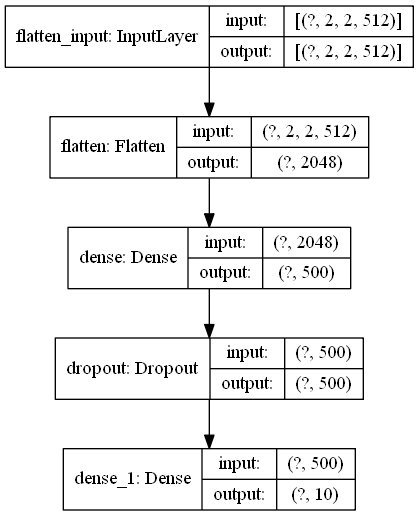

In [ ]:
plot_model(vgg16_model_modified,to_file=os.path.join(os.getcwd(),"model","vgg16","model_distracted_driver_vgg16.png"),show_shapes=True,show_layer_names=True)

In [ ]:
# Create a path to save the check point 
filepath = os.path.join(MODEL_PATH,"distracted-{epoch:02d}-{val_accuracy:.2f}.hdf5")
# Creating chekpoint to save and source control combined into a single package.
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',period=1)
callbacks_list = [checkpoint]

In [ ]:
model_history = vgg16_model_modified.fit(train_vgg16,ytrain,validation_data = (valid_vgg16, ytest),epochs=75, batch_size=16, shuffle=True,callbacks=callbacks_list)

Epoch 1/75
872/874 [============================>.] - ETA: 0s - loss: 1.1251 - accuracy: 0.6177
Epoch 00001: val_accuracy improved from -inf to 0.85170, saving model to C:\Users\Engr Amir\Downloads\Distracted-Driver-Detection-master\model\vgg16_modified\distracted-01-0.85.hdf5
874/874 [==============================] - 22s 25ms/step - loss: 1.1241 - accuracy: 0.6180 - val_loss: 0.4496 - val_accuracy: 0.8517
Epoch 2/75
873/874 [============================>.] - ETA: 0s - loss: 0.5152 - accuracy: 0.8330
Epoch 00002: val_accuracy improved from 0.85170 to 0.90782, saving model to C:\Users\Engr Amir\Downloads\Distracted-Driver-Detection-master\model\vgg16_modified\distracted-02-0.91.hdf5
874/874 [==============================] - 23s 26ms/step - loss: 0.5151 - accuracy: 0.8331 - val_loss: 0.2675 - val_accuracy: 0.9078
Epoch 3/75
872/874 [============================>.] - ETA: 0s - loss: 0.3739 - accuracy: 0.8788
Epoch 00003: val_accuracy improved from 0.90782 to 0.92757, saving model to C:\

874/874 [==============================] - ETA: 0s - loss: 0.1555 - accuracy: 0.9644
Epoch 00025: val_accuracy did not improve from 0.97910
874/874 [==============================] - 21s 24ms/step - loss: 0.1555 - accuracy: 0.9644 - val_loss: 0.1347 - val_accuracy: 0.9754
Epoch 26/75
873/874 [============================>.] - ETA: 0s - loss: 0.1397 - accuracy: 0.9673
Epoch 00026: val_accuracy did not improve from 0.97910
874/874 [==============================] - 21s 24ms/step - loss: 0.1397 - accuracy: 0.9673 - val_loss: 0.1811 - val_accuracy: 0.9662
Epoch 27/75
874/874 [==============================] - ETA: 0s - loss: 0.1352 - accuracy: 0.9689
Epoch 00027: val_accuracy did not improve from 0.97910
874/874 [==============================] - 22s 25ms/step - loss: 0.1352 - accuracy: 0.9689 - val_loss: 0.2169 - val_accuracy: 0.9642
Epoch 28/75
873/874 [============================>.] - ETA: 0s - loss: 0.1359 - accuracy: 0.9681
Epoch 00028: val_accuracy did not improve from 0.97910
874/8

Epoch 52/75
873/874 [============================>.] - ETA: 0s - loss: 0.1289 - accuracy: 0.9767
Epoch 00052: val_accuracy did not improve from 0.98683
874/874 [==============================] - 21s 25ms/step - loss: 0.1289 - accuracy: 0.9767 - val_loss: 0.1332 - val_accuracy: 0.9840
Epoch 53/75
874/874 [==============================] - ETA: 0s - loss: 0.1216 - accuracy: 0.9789
Epoch 00053: val_accuracy did not improve from 0.98683
874/874 [==============================] - 21s 24ms/step - loss: 0.1216 - accuracy: 0.9789 - val_loss: 0.1505 - val_accuracy: 0.9840
Epoch 54/75
872/874 [============================>.] - ETA: 0s - loss: 0.1193 - accuracy: 0.9780
Epoch 00054: val_accuracy did not improve from 0.98683
874/874 [==============================] - 21s 24ms/step - loss: 0.1192 - accuracy: 0.9780 - val_loss: 0.1484 - val_accuracy: 0.9831
Epoch 55/75
874/874 [==============================] - ETA: 0s - loss: 0.1231 - accuracy: 0.9771
Epoch 00055: val_accuracy did not improve from 0

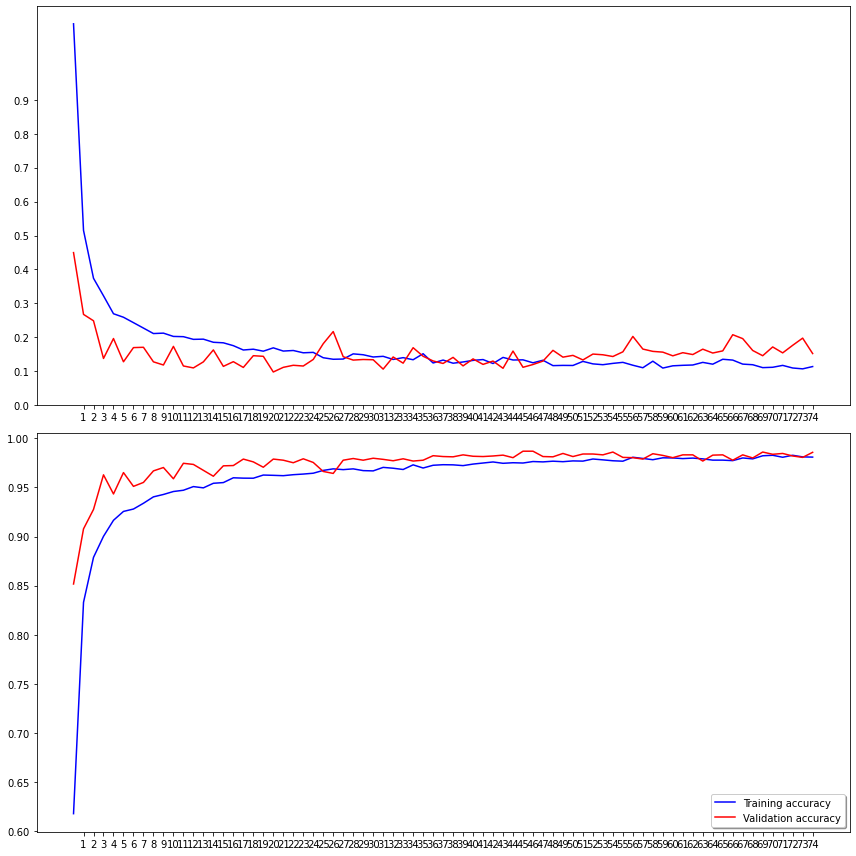

In [ ]:
# displayed comparatively result of train and validation data 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 75, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 75, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Model Analysis
Finding the Confusion matrix,Precision,Recall and F1 score to analyse the model thus created



In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig

In [ ]:
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels.argmax(axis=1),predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)

In [ ]:
class_names = list()
for name,idx in labels_id.items():
    class_names.append(name)
# print(class_names)
ypred = vgg16_model_modified.predict(valid_vgg16,verbose=1)

110/110 [==============================] - 0s 4ms/step


## Confusion Matrix

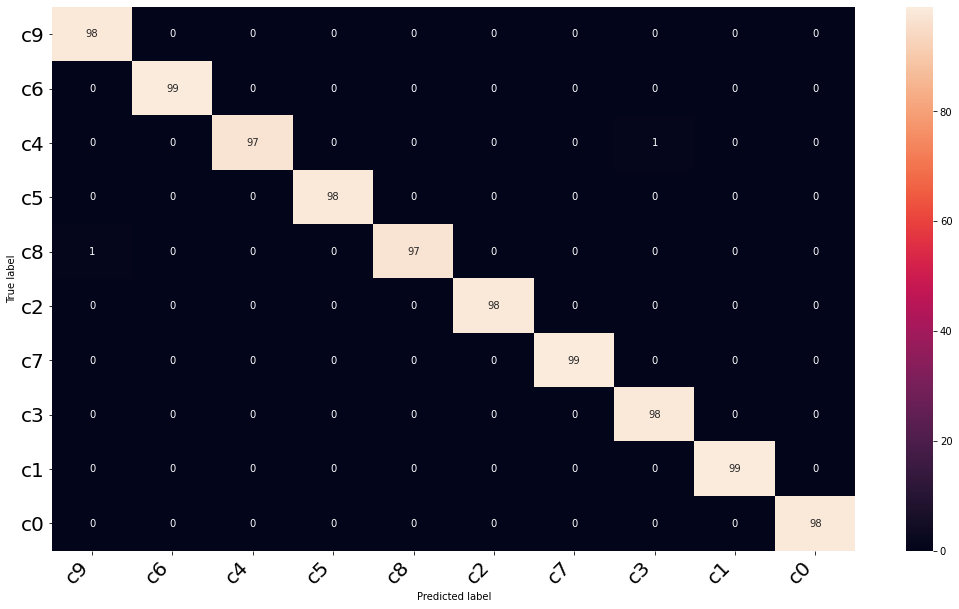

In [ ]:
# Pridicting the accuracy of model by ploting heatmap for True and predicted labels 
print_heatmap(ytest,ypred,class_names)

# Precision Recall F1 Score

In [ ]:
ypred_class = np.argmax(ypred,axis=1)
# print(ypred_class[:10])
ytest = np.argmax(ytest,axis=1)

In [ ]:
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.985686
Precision: 0.985768
Recall: 0.985686
F1 score: 0.985695
